# The Bayesian LASSO Regression

## Rahmat Ashari

**Fall 2021 PGE 383 Subsurface Machine Learning at The University of Texas at Austin**

**Hildebrand Department of Petroleum & Geosystems Engineering - Cockrell School of Engineering**

ra37697 | rahx@utexas.edu | [LinkedIn](https://www.linkedin.com/in/rahmatashari/) | 
_____________________

**Workflow supervision and review by:**

**Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin**

[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

**Course TA: Ademide Mabadeje, Graduate Student, The University of Texas at Austin**

[LinkedIn](https://www.linkedin.com/in/ademidemabadeje/)

## Executive Summary

The LASSO regression can be interpreted from the perspective of Bayesian statistics, where the mode of the posterior distribution can be seen as a point estimate for the parameters. A simple single-predictor model fitting was exercised and compared with the frequentist LASSO regression at different $\lambda$ values. Adopting the Bayesian approach to LASSO regression delivers the capability of assessing the uncertainty in the model parameters, as well as regularization.

## The Mathematical Foundation for Bayesian LASSO

Similarly to simple linear regressions, linear regression with LASSO regularization can be perceived both from the Bayesian and frquesntist paradigms. From a Bayesian point of view, a linear regression model can be expressed as

$$
Y = \mu1 + \sum_{i = 1}^N X \beta_i + \epsilon
$$

where the residuals $\epsilon \sim N(0, \sigma^2)$, a prior $p(\beta) = \prod_{i = 1}^N g(\beta_i)$, and a likelihood $p(y) \sim N(\mu1 + X\beta, \sigma^2I)$. The LASSO regularization is expressed as 

$$
\lambda \sum_{i=1}^N|\beta_i|
$$

where $|\beta_i|$ is the L1 norm. If the prior $g(\beta)$ is a Laplace density with mean 0 and a scale parameter defined as a function of $\lambda$, then the posterior mode for $\beta$ is the LASSO solution (James, 2014). The Laplace prior for the $\beta$ can be parametrized as 

$$
p(\beta | \sigma^2) = \prod\frac{\lambda}{2\sqrt{\sigma^2}} \exp(-\lambda\beta_i/\sqrt{\sigma^2})
$$

The prior is conditioned by $\sigma^2$ to guarantee unimodality in the posterior distribution (Park and Castella, 2008). In a full Bayesian model, a hyperprior can be set for $\lambda$. However, in this workflow, $\lambda$ will be predetermined. 

## Import Dependencies and Workflow Set-ups

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
import pymc3 as pm
import warnings
seed = 2021

# the lines below are purely for aesthetics
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["font.size"] = 12
plt.rcParams['figure.dpi']= 120

# Hide ONLY deprecation warning
warnings.filterwarnings("ignore", category=DeprecationWarning) 

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


**note**

The package `pymc3` is not installed by default with Anaconda/Miniforge installation. For Windows, installation is trivial by using conda. For MacOS (particularly if you are using arm chip), refer to [the formal installation guide](https://github.com/pymc-devs/pymc/wiki/Installation-Guide-(MacOS)).

## Bayesian Lasso Regression

In this section, the goal is to fit a linear regression with LASSO regularization to predict production using only permeability. A synthetic dataset `unconv_MV_v4.csv` will be used. This dataset is available at Dr. Pyrcz's GitHub data repository. In this workflow, the data has been uploaded to my GitHub [reporistory](https://github.com/fraclad/BayesianLassoExpository) and will be read directly from this location. 

### Read Data and Standardization

As an intial step, it is always a good practice to examine the imported data. Unlike in numerous statistical learning approaches, features standardization for a single-predictor linear regression is not highly influential to inferring the model parameters. Thus, in this exercise, the predictor and target features are left in their original scale. 

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/fraclad/BayesianLassoExpository/main/supportingFiles/unconv_MV_v4.csv")
data.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,1695.360819
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3007.096063
2,3,14.02,2.59,4.01,72.80,0.89,2.72,2531.938259
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5288.514854
4,5,17.52,4.57,3.18,10.94,1.51,1.90,2859.469624


The next step is to examine the summary statistics of the data. This step can reveal if there is any extreme outliers present in the dataset. 

In [3]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Well,200.0,100.500000,57.879185,1.000000,50.750000,100.500000,150.250000,200.000000
Por,200.0,14.991150,2.971176,6.550000,12.912500,15.070000,17.402500,23.550000
Perm,200.0,4.330750,1.731014,1.130000,3.122500,4.035000,5.287500,9.870000
AI,200.0,2.968850,0.566885,1.280000,2.547500,2.955000,3.345000,4.630000
Brittle,200.0,48.161950,14.129455,10.940000,37.755000,49.510000,58.262500,84.330000
TOC,200.0,0.990450,0.481588,-0.190000,0.617500,1.030000,1.350000,2.180000
VR,200.0,1.964300,0.300827,0.930000,1.770000,1.960000,2.142500,2.870000
Prod,200.0,3864.407081,1553.277558,839.822063,2686.227611,3604.303506,4752.637555,8590.384044


Only `Perm` and `Prod` columns are needed in this exercise, and both look proper. A quick visualization never hurt!

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


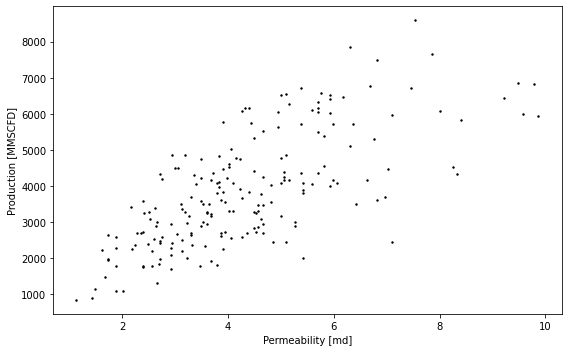

In [4]:
x = data["Perm"]
y = data["Prod"]

plt.figure(figsize = (8,5))
plt.scatter(x, y, color = "black", s = 2)
plt.xlabel("Permeability [md]")
plt.ylabel("Production [MMSCFD]")
plt.tight_layout()
plt.show()

From visual inspection, it is reasonable to fit a linear regression as a model to predict production from permeability.

### Building the Bayesian LASSO Model

In this section, the linear regression model with LASSO regularization will be constructed. The following likelihood and priors are incorporated

$$
\begin{aligned}
p(y | - ) &\sim Normal(\mu1 + X\beta, \sigma^2) \\
p(\beta | -) &\sim Laplace(0, b) \\
p(\sigma^2) &\sim InverseGamma(1, 10) \\
p(\mu) &\sim Flat
\end{aligned}
$$

where $b = \frac{\sqrt{\sigma^2}}{\lambda}$

For this exercise, $\lambda = 10$. The inverse gamma prior for $\sigma^2$ is set to ensure conjugacy (Park and Casella, 2008). Additionally, the choice of the parameters in the prior for $\sigma^2$ is to make the prior non-informative, so that the data can play a larger role in updating the parameters. 

In [5]:
lambd = 10

with pm.Model() as bayesLassoUni:
    # declare priors
    intercept = pm.Flat("intercept")
    sigmaSq = pm.InverseGamma("sigmaSq", alpha = 1, beta = 10)
    beta = pm.Laplace("beta", mu = 0, b = sigmaSq**0.5/lambd)
    
    # construct model
    modelMean = intercept + (beta * x)
    
    # define likelihood
    likelihood = pm.Normal('likelihood', mu = modelMean, sd = sigmaSq**0.5, observed = y)
    
    # set up posterior sampling 
    step = pm.NUTS(target_accept = 0.95)
    
    # get trace and maximum a posteriori (MAP)
    posteriorMode = pm.find_MAP()
    trace = pm.sample(draws = 1000, tune = 4000, step = step, start = posteriorMode,
                      random_seed = seed, return_inferencedata = True)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigmaSq, intercept]


Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 23 seconds.


The mode of the posterior (a.k.a the Bayesian LASSO point estimates for the parameters)

In [6]:
print(posteriorMode)

{'intercept': array(1203.79181425), 'sigmaSq_log__': array(14.00715195), 'beta': array(614.35460452), 'sigmaSq': array(1211236.07654289)}


The summary statistics for the posterior and the diagnostic plots

In [7]:
with bayesLassoUni:
    print(pm.stats.summary(trace))

                  mean          sd       hdi_3%      hdi_97%  mcse_mean  \
intercept     1210.081     213.452      817.845     1630.492      5.504   
beta           613.104      46.295      521.396      696.475      1.207   
sigmaSq    1248006.007  123697.280  1023157.551  1479085.405   3221.440   

            mcse_sd  ess_bulk  ess_tail  r_hat  
intercept     3.893    1507.0    1467.0    1.0  
beta          0.857    1470.0    1902.0    1.0  
sigmaSq    2293.295    1553.0    1708.0    1.0  


Examine the traceplots to see how the chains look like

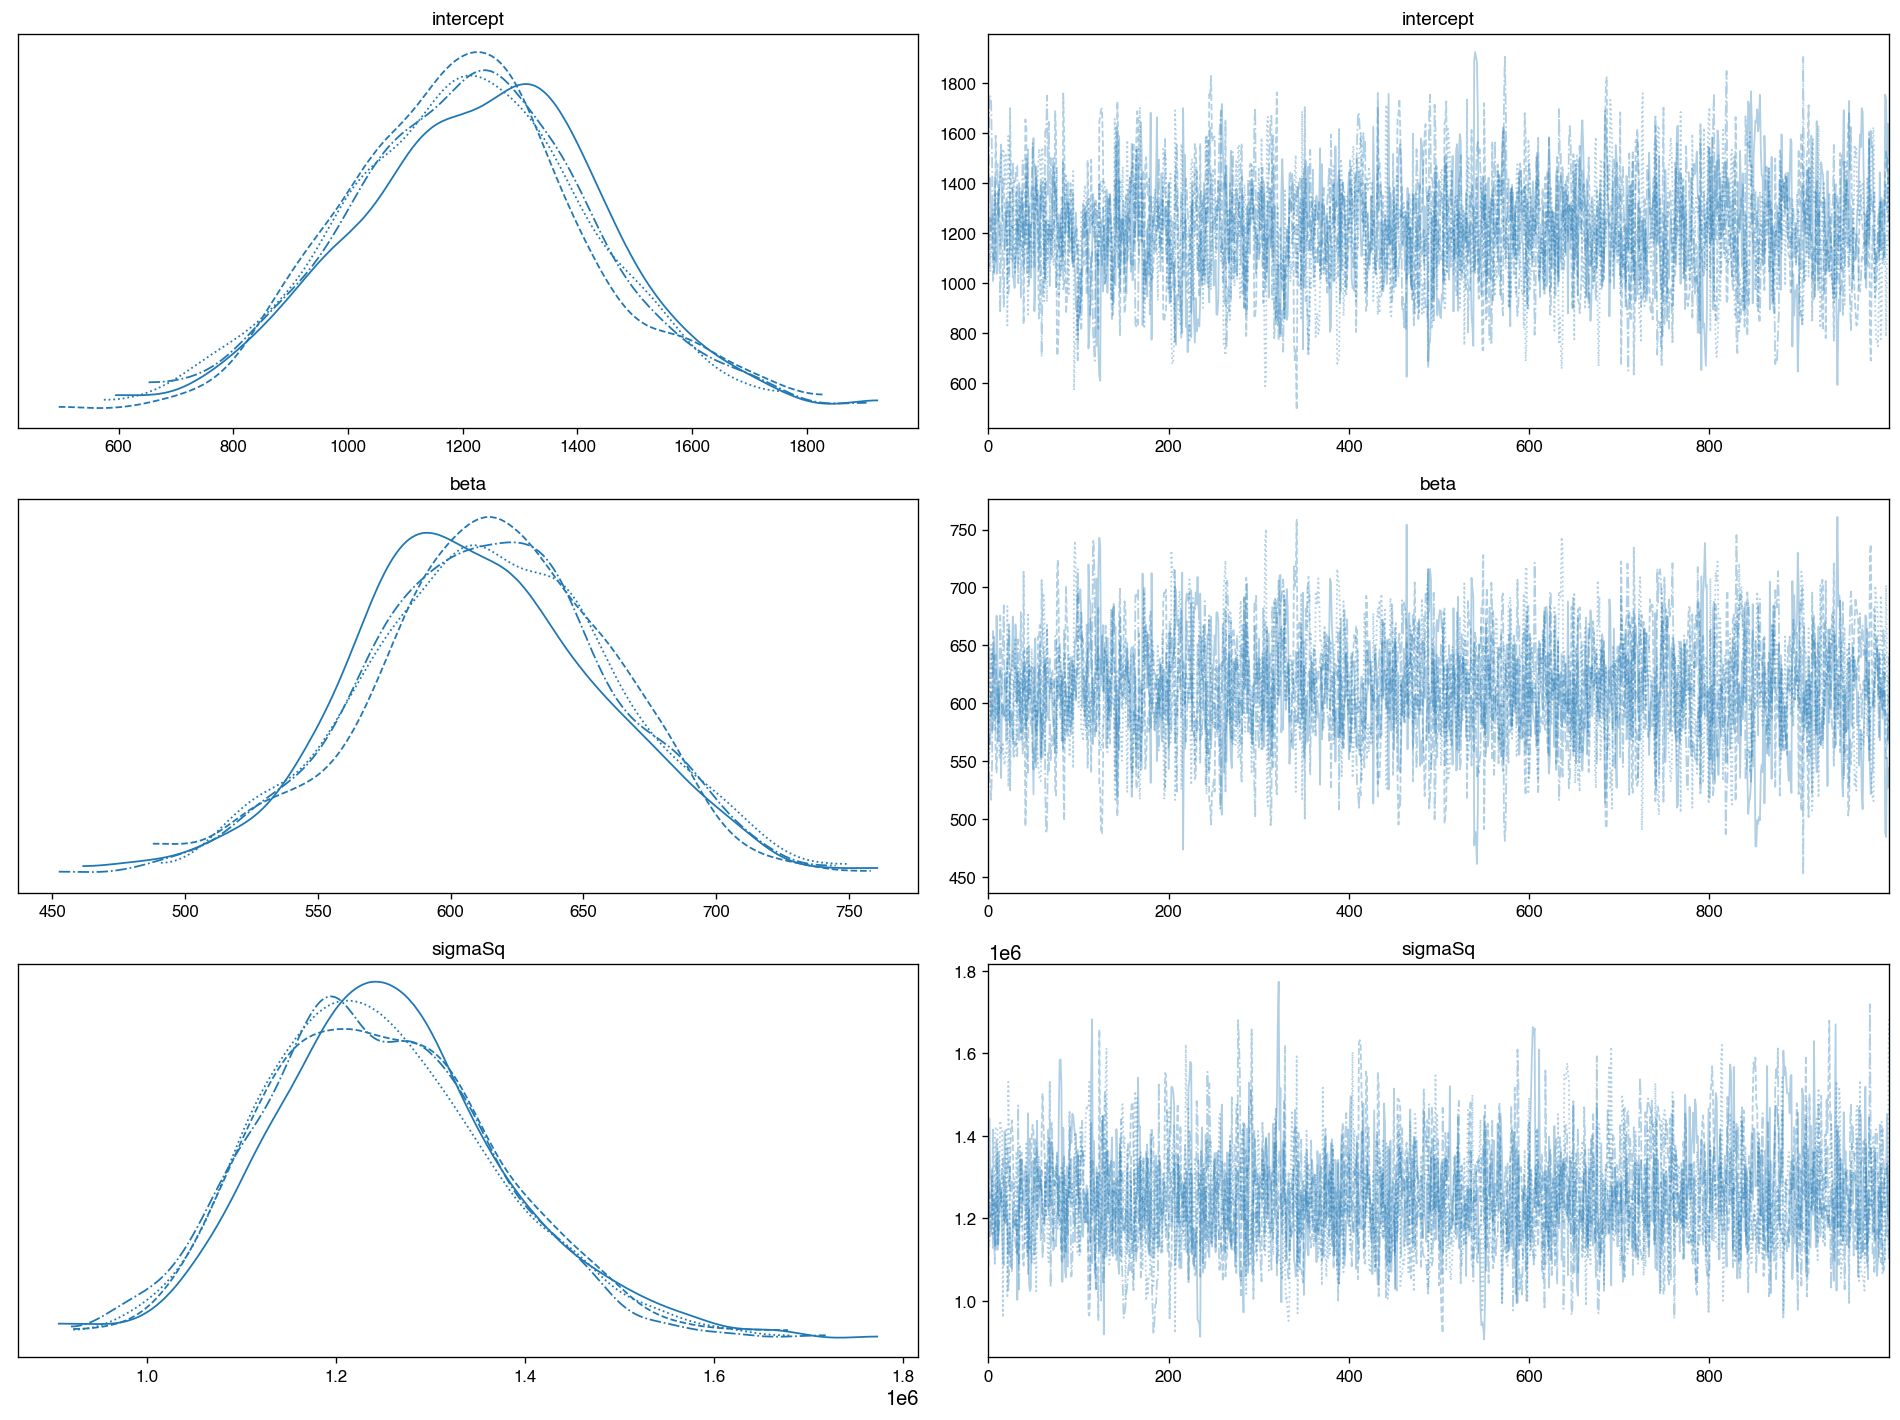

In [8]:
with bayesLassoUni:
    pm.plot_trace(trace, figsize = (16,12))

plt.tight_layout()
plt.show()

The chains look stationary as expected! 

Also notice the posterior distributions are somewhat close to the typical Gaussian density. This indicates that the data plays an big role in updating the prior for the $\beta$ parameter, which was Laplace density. One can expect that if the prior dominates the updating process (which is unfavorable), the posterior would look more like a Laplace distribution rather than Gaussian. 

### Building the Frequentist Lasso Fit

This is simply just to see how frequentist LASSO regularizarion performs for the same predictor and target features for comparison purposes.

In [9]:
# reshape for compatibility
X = x.values.reshape(-1,1)

# Lasso model
modelLasso = Lasso(alpha = lambd)
modelLasso.fit(X,y)
yhatLasso = modelLasso.predict(X)

### Comparing Bayesian with Frequenstist Lasso

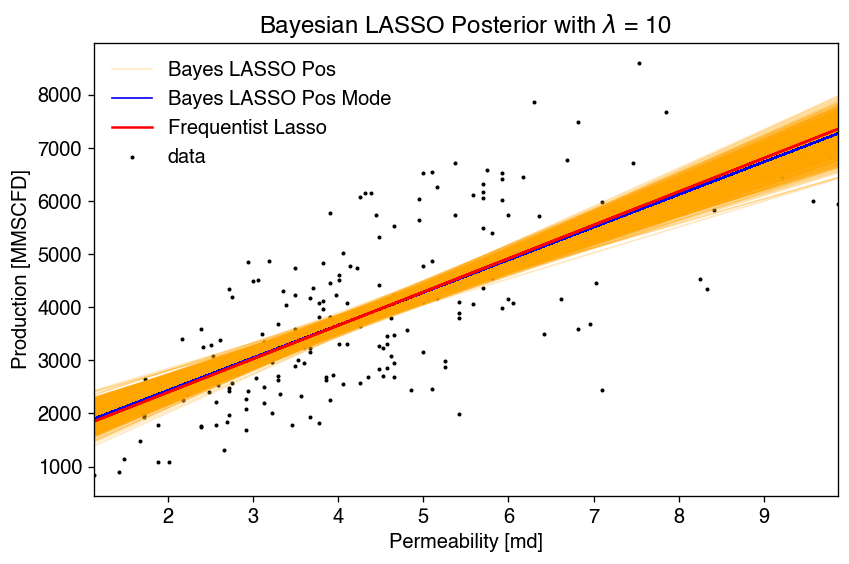

In [10]:
plt.figure(figsize = (8,5))
plt.scatter(x, y, color = "black", label = "data", s = 2)
pm.plot_posterior_predictive_glm(trace, samples = 1000, eval = np.linspace(min(x), max(x), 100), linewidth = 1, color = 'orange', alpha = 0.25, 
                                  label = 'Bayes LASSO Pos',lm = lambda x, sample: sample['intercept'] + sample['beta'] * x)
pm.plot_posterior_predictive_glm(trace, samples = 1000, eval = np.linspace(min(x), max(x), 100), 
                                 linewidth = 1, color = 'blue',
                                 label = 'Bayes LASSO Pos Mode',
                                 lm = lambda x, sample: posteriorMode['intercept'] + posteriorMode['beta'] * x)
plt.plot(x, yhatLasso, color = "red", label = "Frequentist Lasso")
plt.xlabel("Permeability [md]")
plt.ylabel("Production [MMSCFD]")
plotTitle = r"Bayesian LASSO Posterior with $\lambda$ = " + str(lambd)
plt.title(plotTitle)
plt.xlim([min(x), max(x)])
plt.legend(frameon = False)
plt.show()

From visual inspection, the frequentist and Bayesian (point) estimates for the slope appear to be quite close. For the case of Bayesian LASSO regression, we can also assess the whole distribution of the slopes and intercept, which is valuable for uncertainty analysis. In the upcoming chunk, the behaviors of Bayesian LASSO estimates will be exercised at different values of $\lambda$

### The Effects of $\lambda$

**Notice** : Depending on your hardware, this may take a while to run. It took about 1-2 mins on M1 MacBook Air.

In the chunk below, we are building similar model but at different $\lambda$ values

In [11]:
lambdaList = [0.01, 10, 100, 10000]

traceList = []
modeList = []

for l in lambdaList:
    print("processing lambda = {}".format(l))
    with pm.Model() as bayesLassoUni:
        # declare priors
        intercept = pm.Flat("intercept")
        sigmaSq = pm.InverseGamma("sigmaSq", alpha = 1, beta = 10)
        beta = pm.Laplace("beta", mu = 0, b = sigmaSq**0.5/l)

        # construct model
        modelMean = intercept + (beta * x)

        # define likelihood
        likelihood = pm.Normal('likelihood', mu = modelMean, sd = sigmaSq**0.5, observed = y)

        # set up posterior sampling 
        step = pm.NUTS(target_accept = 0.95)

        # get trace and maximum a posteriori (MAP)
        posteriorMode = pm.find_MAP()
        trace = pm.sample(draws = 1000, tune = 4000, step = step, start = posteriorMode,
                          random_seed = seed, return_inferencedata = True)
        
    traceList.append(trace)
    modeList.append(posteriorMode)
    

processing lambda = 0.01


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigmaSq, intercept]


Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 23 seconds.


processing lambda = 10


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigmaSq, intercept]


Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 22 seconds.


processing lambda = 100


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigmaSq, intercept]


Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 22 seconds.


processing lambda = 10000


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigmaSq, intercept]


Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 22 seconds.


Next, the frequentist LASSO regression will be built for different $\lambda$ values, to serve as comparisons

In [12]:
# Frequentist LASSO model
yhatLassoList = []
freqLassoSlope = []
for l in lambdaList:
    modelLasso = Lasso(alpha = l)
    modelLasso.fit(X,y)
    yhatLasso = modelLasso.predict(X)
    yhatLassoList.append(yhatLasso)
    freqLassoSlope.append(round(modelLasso.coef_[0],2))

Visualization to compare how the parameters change at different $\lambda$ values

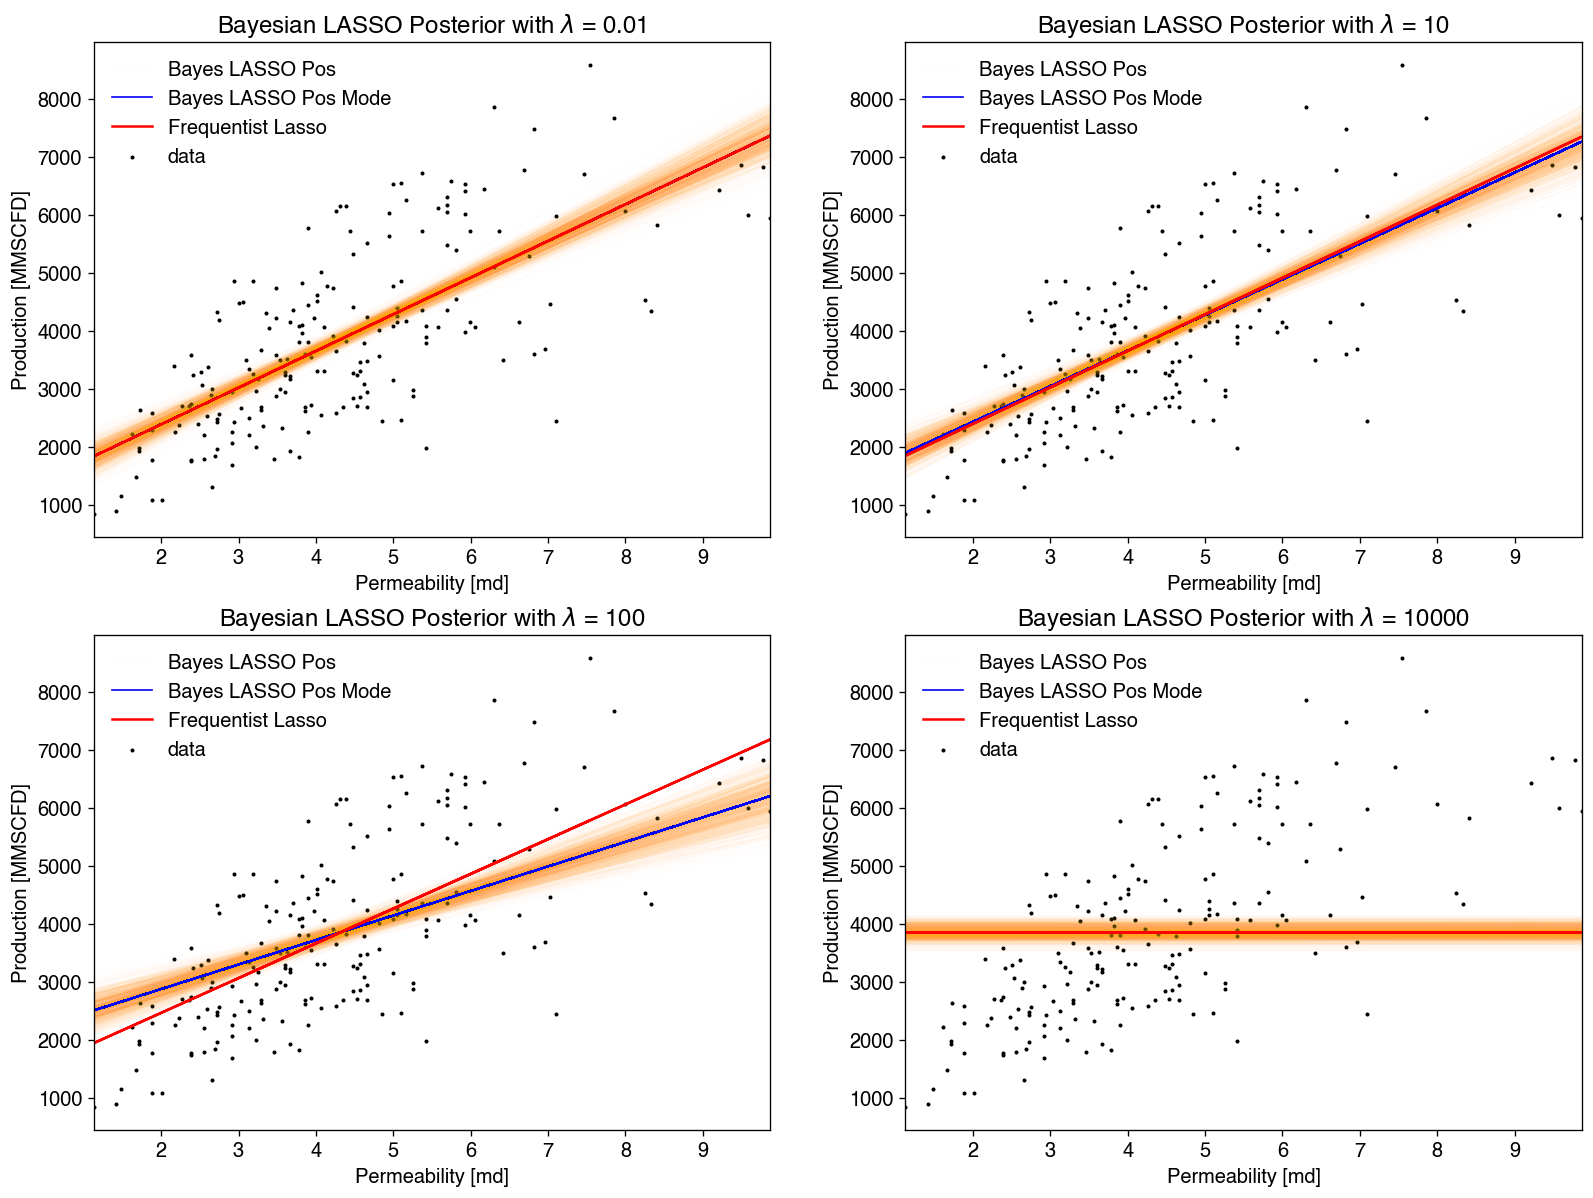

In [13]:
plt.figure(figsize = (16,12))
for idx,l in enumerate(lambdaList):
    plt.subplot(2,2,idx + 1)
    plt.scatter(x, y, color = "black", label = "data", s = 2)
    pm.plot_posterior_predictive_glm(traceList[idx], samples = 1000, eval = np.linspace(min(x), max(x), 100), linewidth = 1, color = 'orange', alpha = 0.01, 
                                     label = 'Bayes LASSO Pos',lm = lambda x, sample: sample['intercept'] + sample['beta'] * x)
    pm.plot_posterior_predictive_glm(traceList[idx], samples = 1000, eval = np.linspace(min(x), max(x), 100), 
                                     linewidth = 1, color = 'blue',
                                     label = 'Bayes LASSO Pos Mode',
                                     lm = lambda x, sample: modeList[idx]['intercept'] + modeList[idx]['beta'] * x)
    plt.plot(x, yhatLassoList[idx], color = "red", label = "Frequentist Lasso")
    plt.xlabel("Permeability [md]")
    plt.ylabel("Production [MMSCFD]")
    if idx == 0:
        plotTitle = r"Bayesian LASSO Posterior with $\lambda$ = " + str(l)
    else:
        plotTitle = r"Bayesian LASSO Posterior with $\lambda$ = " + str(int(l))
    plt.title(plotTitle)
    plt.xlim([min(x), max(x)])
    plt.legend(frameon = False)
plt.show()

Notice that for both Bayesian and frequentist approaches to LASSO regression, the slope decreases with increasing value of $\lambda$ as expected. At extremely high value of $\lambda$, the slopes from both approaches lie in the global average of the target feature, (again) as expected. **However** judging from the case with $\lambda = 100$, the Bayesian LASSO approach seems to drop the slope faster than the frequentist approach. To explain this phenomenon, notice that in the model specification, the prior for the $\beta$ parameter was set to be 

```
beta = pm.Laplace("beta", mu = 0, b = sigmaSq**0.5/l)
```

With increasing $\lambda$, the scale parameter for the Laplace prior shrinks. This translates to greater '*certainty*' in the prior that the slope is close to 0, which presents a smaller slope departure from 0 after similar Bayes updating configuration (this in turns, gives the sense that the slope drops faster!). Perhaps, this effect will become less pronounced if the dataset had more observations.

The dataframe below further elucidates the changes in slope with increasing $\lambda$

In [14]:
betaList = [round(float(modeList[i]["beta"]), 2) for i in range(len(modeList))]
slopeCompareDf = pd.DataFrame({"lambda": lambdaList, "slope bayes": betaList, "slope freq": freqLassoSlope})
slopeCompareDf

,lambda,slope bayes,slope freq
0,0.01,632.79,632.81
1,10.00,614.35,629.46
2,100.00,423.13,599.27
3,10000.00,-0.00,0.00


It is apparent that for small to intermediate values of $\lambda$, the Bayesian estimates for LASSO regression are similar to those of frequentist LASSO regression.

## Summary

In this workflow, a Bayesian LASSO regression was modeled to predict production from permeability. When compared with frequentist LASSO regression, the solutions were similar except at large $\lambda$ values. The Bayesian and frequenstist LASSO models behave similarly with increasing $\lambda$. Exercising LASSO regression from the Bayesian perspective enables modelers to evaluate the uncertainties in the model parameters, while still being capable to regularize the model.

## Further Exploration

A Bayesian LASSO regression exposition in multivariate setting is mathematically intriguing. For such exercise, multiple interesting aspects can be explored. For example, the posterior distribution of each predictor feature can be assessed. The evolution of the coefficient of each predictor feature with various values of $\lambda$ can also be examined.

## References

James, Gareth. An Introduction To Statistical Learning. Springer, 2014.

Park, Trevor, and George Casella. "The Bayesian Lasso". Journal Of The American Statistical Association, vol 103, no. 482, 2008, pp. 681-686. Informa UK Limited, https://doi.org/10.1198/016214508000000337. 